# TXST DATATHON: Library Resource Reallocation

## Research Question:
### "What does a decade of TXST Library circulation data reveal about
###  the shift from physical collections to technology and space demand,
###  and how should the library prioritize its resource reallocation?"


In [31]:
# ===============================================
# TXST DATATHON: Library Resource Reallocation
# 
# ===============================================
# Research Question:
# "What does a decade of TXST Library circulation data reveal about
#  the shift from physical collections to technology and space demand,
#  and how should the library prioritize its resource reallocation?"
# ===============================================

# 1) Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.gridspec import GridSpec
import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor': '#f8f9fa',
    'axes.grid': True,
    'grid.alpha': 0.3,
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.titleweight': 'bold',
    'figure.titlesize': 16,
    'figure.titleweight': 'bold',
})

TXST_GOLD = '#6a5638'
TXST_MAROON = '#501214'
TXST_CREAM = '#d4c9a8'
COLORS = ['#501214', '#6a5638', '#d4c9a8', '#8b6914', '#2d5f2d', '#1a5276', '#c0392b']

print("Imports and style loaded.")



Imports and style loaded.


In [32]:
import pandas as pd

DATA_PATH = "TXST_Library_Circulation_Enrollment_Clean.xlsx"
IPEDS_PATH = "IPEDS Enrollment Data 2019-2024.csv"

# =========================
# LOAD CLEAN LIBRARY DATA
# =========================
summary_df = pd.read_excel(DATA_PATH, sheet_name="Annual Summary")
type_df    = pd.read_excel(DATA_PATH, sheet_name="Circulation by Type")
patron_df  = pd.read_excel(DATA_PATH, sheet_name="Circulation by Patron")
loc_raw    = pd.read_excel(DATA_PATH, sheet_name="Circulation by Location")

# Patron cleanup (remove note rows / blanks)
patron_df = patron_df[pd.to_numeric(patron_df["Fiscal Year"], errors="coerce").notna()].copy()
patron_df["Fiscal Year"] = patron_df["Fiscal Year"].astype(int)
patron_df = patron_df.rename(columns={"Fiscal Year": "Fiscal_Year", "Grand Total": "Grand_Total"})

# Build circ_df from Annual Summary (FULL range: FY2014–FY2024)
circ_df = (summary_df[["Fiscal Year", "Annual Circulation"]]
           .rename(columns={"Fiscal Year": "FY", "Annual Circulation": "Annual_Total"})
           .copy())
circ_df["FY"] = pd.to_numeric(circ_df["FY"], errors="coerce").astype(int)
circ_df["Annual_Total"] = pd.to_numeric(circ_df["Annual_Total"], errors="coerce")
circ_df = circ_df.sort_values("FY").reset_index(drop=True)

print(f"Circulation data range: FY{circ_df['FY'].min()}–FY{circ_df['FY'].max()} ({len(circ_df)} years)")
print(circ_df.to_string(index=False))

# =========================
# LOAD ENROLLMENT DATA (IPEDS) - single source
# =========================
enrollment = pd.read_csv(IPEDS_PATH)  # will fail loudly if missing
enrollment["Institution (entity) name"] = (
    enrollment["Institution (entity) name"].astype(str).str.strip().str.lower()
)

txst = enrollment[enrollment["Institution (entity) name"].str.contains("texas state", na=False)].copy()
txst["Grand total"] = pd.to_numeric(txst["Grand total"], errors="coerce")
txst["Year"] = pd.to_numeric(txst["Year"], errors="coerce").astype(int)

enroll_yearly = (txst.groupby("Year")["Grand total"]
                 .max()
                 .reset_index()
                 .rename(columns={"Year": "FY", "Grand total": "Enrollment"})
                 .sort_values("FY"))

# Only keep the FYs we need (prevents extra rows from causing confusion)
enroll_yearly = enroll_yearly[enroll_yearly["FY"].between(2019, 2024)].copy()

print("\nEnrollment data:")
print(enroll_yearly.to_string(index=False))

# =========================
# MERGE + PER STUDENT (only FY2019–2024 where we have both datasets)
# =========================
circ_recent = circ_df[circ_df["FY"].between(2019, 2024)].copy()
merged = circ_recent.merge(enroll_yearly, on="FY", how="left")

missing = merged.loc[merged["Enrollment"].isna(), "FY"].tolist()
if missing:
    raise ValueError(f"Missing enrollment for FY(s): {missing}")

if merged["FY"].duplicated().any():
    raise ValueError("Duplicate FY rows after merge — check your inputs.")

merged["Circ_Per_Student"] = merged["Annual_Total"] / merged["Enrollment"]

print("\n=== Merged: Circulation + Enrollment (FY2019–2024) ===")
print(merged[["FY", "Annual_Total", "Enrollment", "Circ_Per_Student"]].to_string(index=False))


Circulation data range: FY2014–FY2024 (11 years)
  FY  Annual_Total
2014        152664
2015        172909
2016        161701
2017        159229
2018        142201
2019        111846
2020         86065
2021         61659
2022         64315
2023         60726
2024         64090

Enrollment data:
  FY  Enrollment
2019       42780
2020       42292
2021       42111
2022       41900
2023       41676
2024       42138

=== Merged: Circulation + Enrollment (FY2019–2024) ===
  FY  Annual_Total  Enrollment  Circ_Per_Student
2019        111846       42780          2.614446
2020         86065       42292          2.035018
2021         61659       42111          1.464202
2022         64315       41900          1.534964
2023         60726       41676          1.457098
2024         64090       42138          1.520955


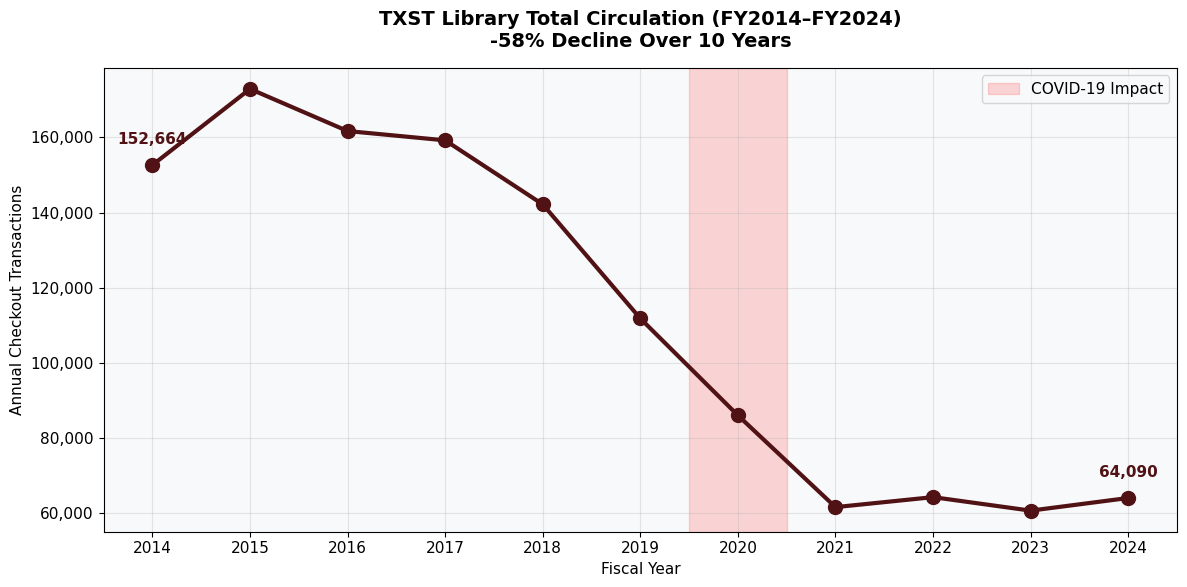

 Saved: 01_total_circulation_trend.png


In [33]:

# ============================================================
#  VIZ 1 — Total Circulation Decline (Full Decade)
# ============================================================

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(circ_df['FY'], circ_df['Annual_Total'], 
        color=TXST_MAROON, linewidth=3, marker='o', markersize=10, zorder=5)
ax.axvspan(2019.5, 2020.5, alpha=0.15, color='red', label='COVID-19 Impact')

# Annotate first and last points
ax.annotate(f"{circ_df.iloc[0]['Annual_Total']:,.0f}", 
            (circ_df.iloc[0]['FY'], circ_df.iloc[0]['Annual_Total']),
            textcoords="offset points", xytext=(0, 15), ha='center',
            fontsize=11, fontweight='bold', color=TXST_MAROON)
ax.annotate(f"{circ_df.iloc[-1]['Annual_Total']:,.0f}", 
            (circ_df.iloc[-1]['FY'], circ_df.iloc[-1]['Annual_Total']),
            textcoords="offset points", xytext=(0, 15), ha='center',
            fontsize=11, fontweight='bold', color=TXST_MAROON)

total_decline = (circ_df.iloc[-1]['Annual_Total'] - circ_df.iloc[0]['Annual_Total']) / circ_df.iloc[0]['Annual_Total'] * 100
fy_start = circ_df['FY'].min()
fy_end = circ_df['FY'].max()

ax.set_title(f'TXST Library Total Circulation (FY{fy_start}–FY{fy_end})\n{total_decline:.0f}% Decline Over {fy_end - fy_start} Years', pad=15)
ax.set_xlabel('Fiscal Year')
ax.set_ylabel('Annual Checkout Transactions')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'{x:,.0f}'))
ax.set_xticks(range(fy_start, fy_end + 1))
ax.legend(fontsize=11)
plt.tight_layout()
plt.savefig('01_total_circulation_trend.png', dpi=200, bbox_inches='tight')
plt.show()
print(" Saved: 01_total_circulation_trend.png")


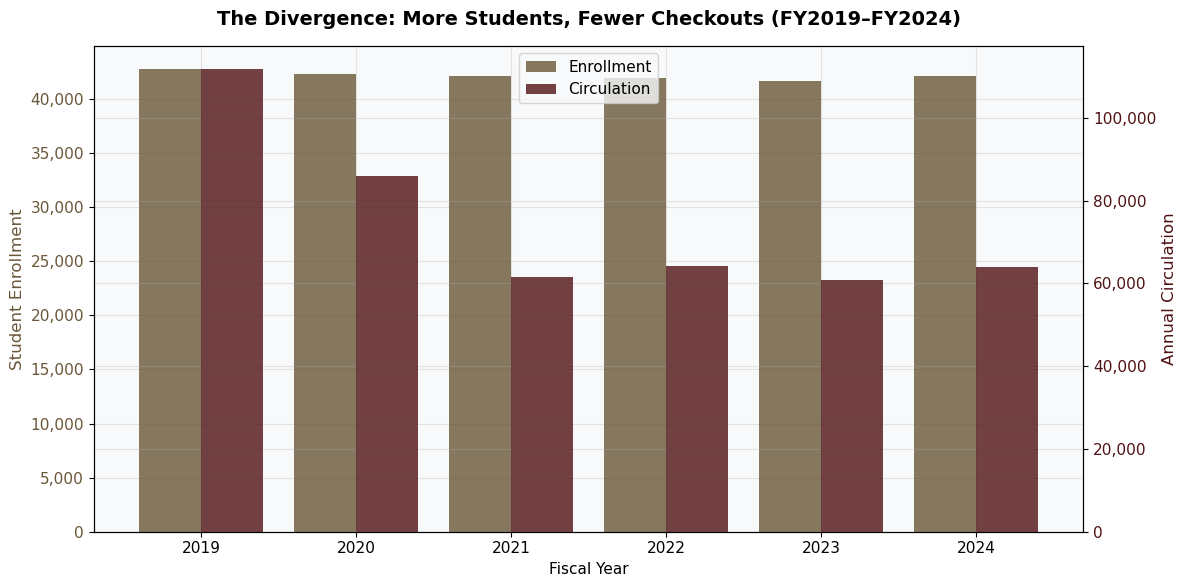

 Saved: 02_divergence.png


In [34]:
# ============================================================
#  VIZ 2 — Enrollment UP vs Circulation DOWN
# ============================================================

fig, ax1 = plt.subplots(figsize=(12, 6))
combo = merged.dropna(subset=['Enrollment'])

ax1.bar(combo['FY'] - 0.2, combo['Enrollment'], width=0.4, 
        color=TXST_GOLD, alpha=0.8, label='Enrollment', zorder=3)
ax1.set_ylabel('Student Enrollment', fontsize=12, color=TXST_GOLD)
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'{x:,.0f}'))
ax1.tick_params(axis='y', labelcolor=TXST_GOLD)

ax2 = ax1.twinx()
ax2.bar(combo['FY'] + 0.2, combo['Annual_Total'], width=0.4,
        color=TXST_MAROON, alpha=0.8, label='Circulation', zorder=3)
ax2.set_ylabel('Annual Circulation', fontsize=12, color=TXST_MAROON)
ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'{x:,.0f}'))
ax2.tick_params(axis='y', labelcolor=TXST_MAROON)

ax1.set_title('The Divergence: More Students, Fewer Checkouts (FY2019–FY2024)', pad=15)
ax1.set_xlabel('Fiscal Year')
ax1.set_xticks(combo['FY'].astype(int))

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center', fontsize=11)
plt.tight_layout()
plt.savefig('02_divergence.png', dpi=200, bbox_inches='tight')
plt.show()
print(" Saved: 02_divergence.png")

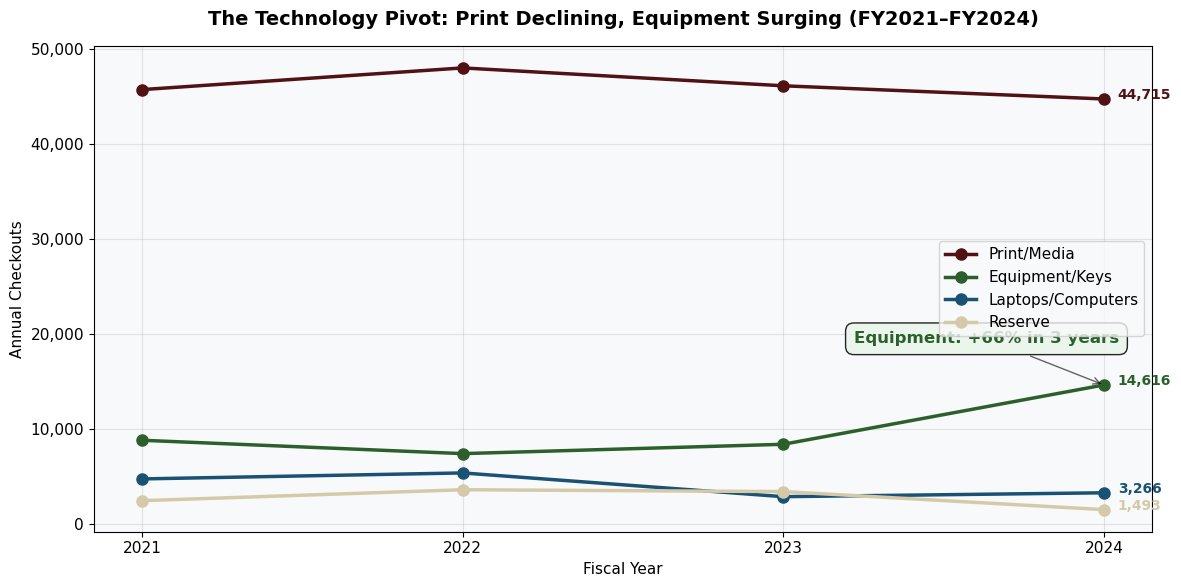

 Saved: 03_technology_pivot.png


In [35]:
# ============================================================
#  VIZ 3 — The Technology Pivot (FY21–FY24)
# ============================================================

tech_df = type_df.copy()

# FY column already exists per your error message, but keep robust:
if "Fiscal Year" in tech_df.columns:
    tech_df = tech_df.rename(columns={"Fiscal Year": "FY"})
tech_df["FY"] = pd.to_numeric(tech_df["FY"], errors="coerce")
tech_df = tech_df.dropna(subset=["FY"]).copy()
tech_df["FY"] = tech_df["FY"].astype(int)

tech_df = tech_df[tech_df["FY"].between(2021, 2024)].copy().sort_values("FY")

categories = {
    "Print/Media": ("Print/Media", TXST_MAROON),
    "Equipment/Keys": ("Equipment/Keys", "#2d5f2d"),
    "Laptops/Computers": ("Laptops/Computers", "#1a5276"),
    "Reserve": ("Reserve", TXST_CREAM),
}

missing_cols = [col for (col, _) in categories.values() if col not in tech_df.columns]
if missing_cols:
    raise KeyError(f"Missing these columns in type_df: {missing_cols}\nColumns: {tech_df.columns.tolist()}")

fig, ax = plt.subplots(figsize=(12, 6))

for label, (col, color) in categories.items():
    y = pd.to_numeric(tech_df[col], errors="coerce").values
    ax.plot(tech_df["FY"], y, marker="o", linewidth=2.5, markersize=8,
            label=label, color=color)

    ax.annotate(f"{y[-1]:,.0f}",
                (tech_df["FY"].iloc[-1], y[-1]),
                textcoords="offset points", xytext=(10, 0),
                fontsize=10, fontweight="bold", color=color)

# Equipment growth annotation
start = pd.to_numeric(tech_df.iloc[0]["Equipment/Keys"], errors="coerce")
end   = pd.to_numeric(tech_df.iloc[-1]["Equipment/Keys"], errors="coerce")

if pd.notna(start) and pd.notna(end) and start != 0:
    equip_growth = (end - start) / start * 100
    ax.annotate(f"Equipment: +{equip_growth:.0f}% in 3 years",
                xy=(tech_df["FY"].iloc[-1], end),
                xytext=(-180, 30), textcoords="offset points",
                fontsize=12, fontweight="bold", color="#2d5f2d",
                bbox=dict(boxstyle="round,pad=0.5", facecolor="#e8f5e9", alpha=0.85),
                arrowprops=dict(arrowstyle="->", alpha=0.6))

ax.set_title("The Technology Pivot: Print Declining, Equipment Surging (FY2021–FY2024)", pad=15)
ax.set_xlabel("Fiscal Year")
ax.set_ylabel("Annual Checkouts")
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f"{x:,.0f}"))
ax.set_xticks([2021, 2022, 2023, 2024])
ax.legend(fontsize=11, loc="center right", frameon=True)

plt.tight_layout()
plt.savefig("03_technology_pivot.png", dpi=200, bbox_inches="tight")
plt.show()

print(" Saved: 03_technology_pivot.png")


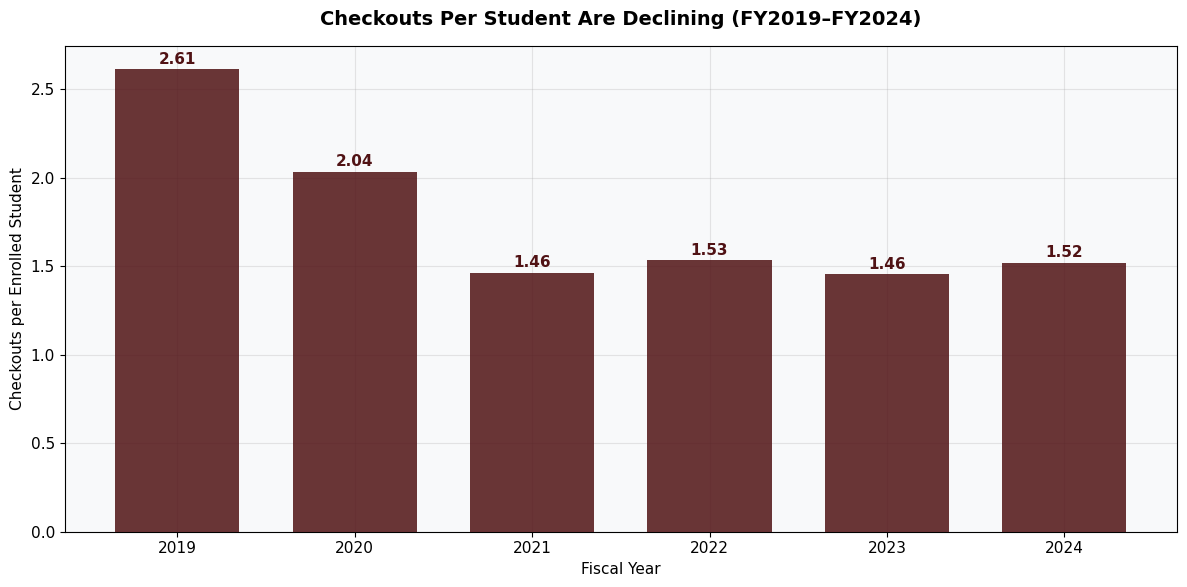

 Saved: 06_per_capita_circulation.png


In [36]:
# ============================================================
# VIZ 6 — Per-Capita Circulation
# ============================================================

per_cap = merged.dropna(subset=['Circ_Per_Student']).copy()

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(per_cap['FY'], per_cap['Circ_Per_Student'], color=TXST_MAROON, alpha=0.85, width=0.7, zorder=3)

for _, row in per_cap.iterrows():
    ax.text(row['FY'], row['Circ_Per_Student'] + 0.03, 
            f"{row['Circ_Per_Student']:.2f}", ha='center', fontsize=11, 
            fontweight='bold', color=TXST_MAROON)

ax.set_title('Checkouts Per Student Are Declining (FY2019–FY2024)', pad=15)
ax.set_xlabel('Fiscal Year')
ax.set_ylabel('Checkouts per Enrolled Student')
ax.set_xticks(per_cap['FY'].astype(int))
plt.tight_layout()
plt.savefig('06_per_capita_circulation.png', dpi=200, bbox_inches='tight')
plt.show()
print(" Saved: 06_per_capita_circulation.png")


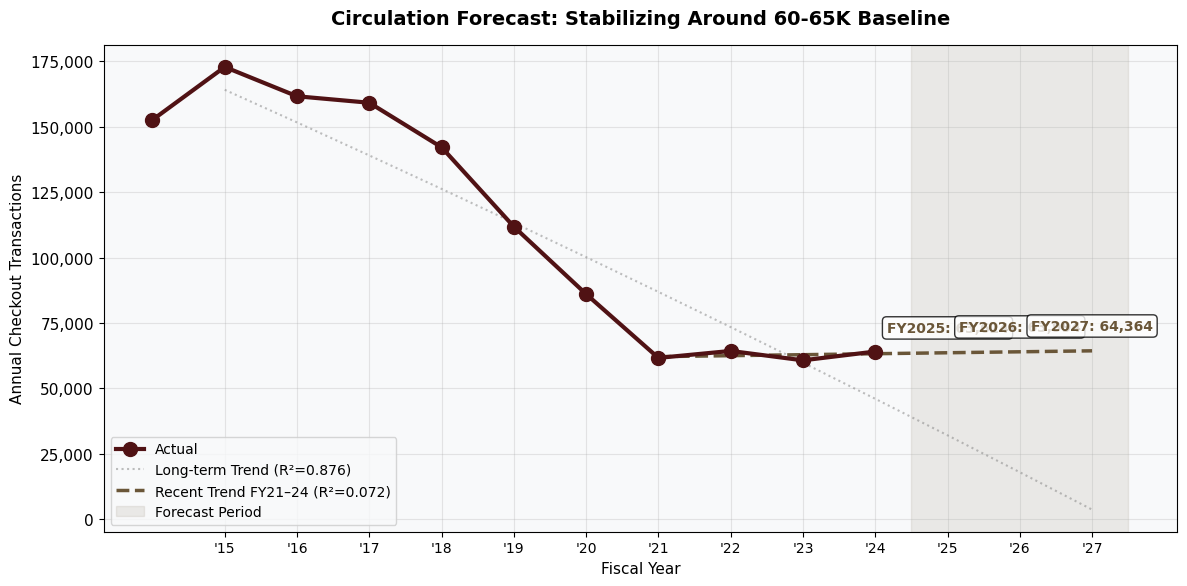


📊 Forecast Results:
  Long-term quadratic R²: 0.8760
  Recent linear R² (FY21-24): 0.0721
  Recent trend: ~+370 transactions/year
  FY2025 projected: 63,624
  FY2026 projected: 63,994
  FY2027 projected: 64,364
Saved: 07_circulation_forecast.png


In [37]:
# ============================================================
# PREDICTIVE — Circulation Forecast
# ============================================================
# Use two models: full-range quadratic + recent 4-year linear (stabilization)

from sklearn.metrics import r2_score

fig, ax = plt.subplots(figsize=(12, 6))

x = circ_df['FY'].values
y = circ_df['Annual_Total'].values

# Quadratic on full data
coeffs2 = np.polyfit(x, y, 2)
poly2 = np.poly1d(coeffs2)
r2_quad = r2_score(y, poly2(x))

# Linear on RECENT data only (FY21-FY24) to show stabilization
x_recent = circ_df[circ_df['FY'] >= 2021]['FY'].values
y_recent = circ_df[circ_df['FY'] >= 2021]['Annual_Total'].values
coeffs_recent = np.polyfit(x_recent, y_recent, 1)
poly_recent = np.poly1d(coeffs_recent)
r2_recent = r2_score(y_recent, poly_recent(x_recent))

future_years = np.arange(2015, 2028)
future_recent = np.arange(2021, 2028)

ax.plot(x, y, color=TXST_MAROON, linewidth=3, marker='o', markersize=10, label='Actual', zorder=5)
ax.plot(future_years, np.maximum(poly2(future_years), 0), color='gray', linewidth=1.5, 
        linestyle=':', alpha=0.5, label=f'Long-term Trend (R²={r2_quad:.3f})')
ax.plot(future_recent, poly_recent(future_recent), color=TXST_GOLD, linewidth=2.5, 
        linestyle='--', label=f'Recent Trend FY21–24 (R²={r2_recent:.3f})', zorder=4)

ax.axvspan(2024.5, 2027.5, alpha=0.1, color=TXST_GOLD, label='Forecast Period')

for yr in [2025, 2026, 2027]:
    val = poly_recent(yr)
    ax.annotate(f'FY{yr}: {val:,.0f}', (yr, val),
                textcoords="offset points", xytext=(0, 15), ha='center',
                fontsize=10, fontweight='bold', color=TXST_GOLD,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

ax.set_title('Circulation Forecast: Stabilizing Around 60-65K Baseline', pad=15)
ax.set_xlabel('Fiscal Year')
ax.set_ylabel('Annual Checkout Transactions')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'{x:,.0f}'))
ax.set_xticks(range(2015, 2028))
ax.set_xticklabels([f"'{str(y)[2:]}" for y in range(2015, 2028)], fontsize=10)
ax.legend(fontsize=10)
plt.tight_layout()
plt.savefig('07_circulation_forecast.png', dpi=200, bbox_inches='tight')
plt.show()

print(f"\n📊 Forecast Results:")
print(f"  Long-term quadratic R²: {r2_quad:.4f}")
print(f"  Recent linear R² (FY21-24): {r2_recent:.4f}")
print(f"  Recent trend: ~{coeffs_recent[0]:+,.0f} transactions/year")
print(f"  FY2025 projected: {poly_recent(2025):,.0f}")
print(f"  FY2026 projected: {poly_recent(2026):,.0f}")
print(f"  FY2027 projected: {poly_recent(2027):,.0f}")
print("Saved: 07_circulation_forecast.png")

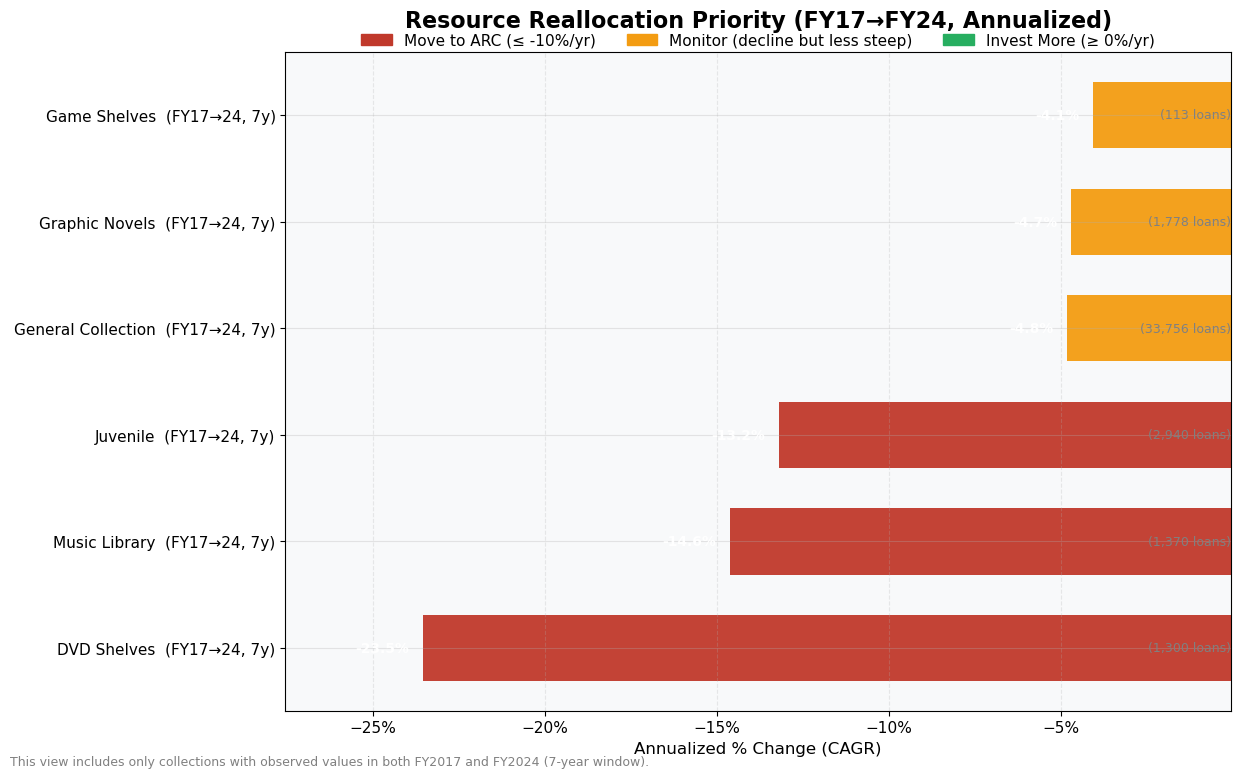

Saved: 09_reallocation_priority_FY17_24.png


,collection,period,years,start,end,annual_cagr_pct,current_loans,band
0,General Collection,FY17→24,7,47703.0,33756.0,-4.820458,33756.0,monitor
1,DVD Shelves,FY17→24,7,8514.0,1300.0,-23.545793,1300.0,move-to-arc
2,Graphic Novels,FY17→24,7,2493.0,1778.0,-4.713818,1778.0,monitor
3,Juvenile,FY17→24,7,7919.0,2940.0,-13.198889,2940.0,move-to-arc
4,Game Shelves,FY17→24,7,151.0,113.0,-4.056734,113.0,monitor
5,Music Library,FY17→24,7,4141.0,1370.0,-14.616566,1370.0,move-to-arc


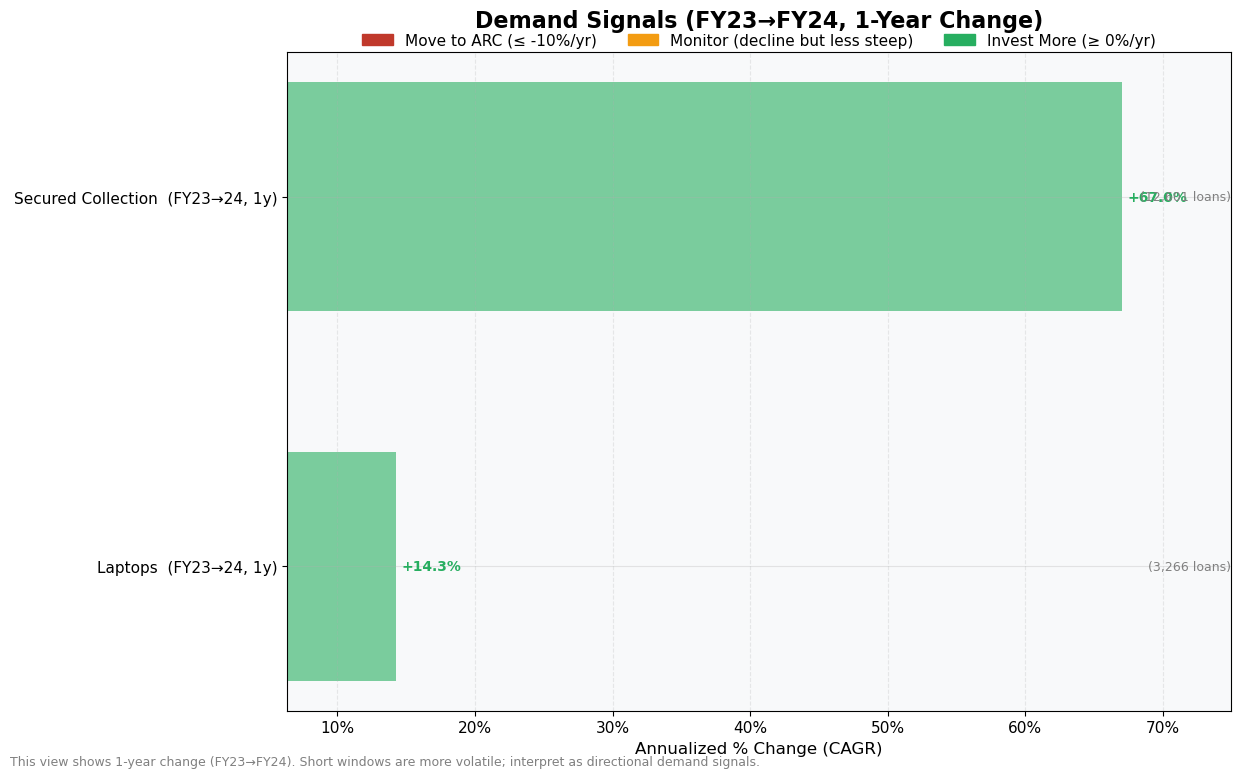

Saved: 10_demand_signals_FY23_24.png


,collection,period,years,start,end,annual_cagr_pct,current_loans,band
7,Laptops,FY23→24,1,2858.0,3266.0,14.275717,3266.0,invest-more
8,Secured Collection,FY23→24,1,7544.0,12601.0,67.033404,12601.0,invest-more


In [38]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker

# ============================================================
# Integrity helpers
# ============================================================
def parse_fy_period(period: str) -> tuple[int, int, int]:
    p = period.replace("->", "→").replace("–", "→")
    nums = re.findall(r"\d{2}", p)
    if len(nums) < 2:
        raise ValueError(f"Could not parse period: {period}")
    s = 2000 + int(nums[0])
    e = 2000 + int(nums[1])
    years = e - s
    if years <= 0:
        raise ValueError(f"Invalid period span: {period}")
    return s, e, years

def cagr_percent(start: float, end: float, years: int) -> float:
    if years <= 0 or start <= 0:
        return np.nan
    return ((end / start) ** (1/years) - 1) * 100

# Bands (simple + defensible)
STEEP_DECLINE_PCT = -10.0
def band_from_cagr(cagr: float) -> str:
    if np.isnan(cagr):
        return "insufficient"
    if cagr <= STEEP_DECLINE_PCT:
        return "move-to-arc"
    if cagr < 0:
        return "monitor"
    return "invest-more"

COLOR = {
    "move-to-arc": "#c0392b",
    "monitor": "#f39c12",
    "invest-more": "#27ae60",
    "insufficient": "#7f8c8d",
}

def plot_priority(df, title, footnote, filename):
    df = df.sort_values("annual_cagr_pct").reset_index(drop=True)

    fig, ax = plt.subplots(figsize=(12.5, 7.8))
    y = np.arange(len(df))

    # Bars
    for i, r in enumerate(df.itertuples(index=False)):
        ax.barh(
            i, r.annual_cagr_pct,
            color=COLOR[r.band],
            alpha=r.alpha,
            height=0.62
        )

    # Y labels include period explicitly
    labels = [f"{r.collection}  ({r.period}, {int(r.years)}y)" for r in df.itertuples(index=False)]
    ax.set_yticks(y)
    ax.set_yticklabels(labels, fontsize=11)

    # 0 line and grid
    ax.axvline(0, color="black", lw=1)
    ax.grid(axis="x", linestyle="--", alpha=0.25)
    ax.xaxis.set_major_formatter(mticker.PercentFormatter(decimals=0))
    ax.set_xlabel("Annualized % Change (CAGR)", fontsize=12)

    # x-limits
    x_min = np.nanmin(df["annual_cagr_pct"].values)
    x_max = np.nanmax(df["annual_cagr_pct"].values)
    pad = max(4, 0.15 * (x_max - x_min if np.isfinite(x_max - x_min) else 10))
    ax.set_xlim(x_min - pad, x_max + pad)
    x_right = ax.get_xlim()[1]

    # Annotations: CAGR + current volume
    for i, r in enumerate(df.itertuples(index=False)):
        c = r.annual_cagr_pct
        curr = r.current_loans

        if np.isnan(c):
            ax.text(0.5, i, "n/a", va="center", ha="left", fontsize=10, color="#2c3e50")
        elif c < 0:
            ax.text(c - 0.4, i, f"{c:.1f}%", va="center", ha="right",
                    fontsize=10, fontweight="bold", color="white")
        else:
            ax.text(c + 0.4, i, f"+{c:.1f}%", va="center", ha="left",
                    fontsize=10, fontweight="bold", color=COLOR["invest-more"])

        ax.text(x_right, i, f"({int(curr):,} loans)", va="center", ha="right",
                fontsize=9, color="gray")

    # Legend
    legend_handles = [
        mpatches.Patch(color=COLOR["move-to-arc"], label=f"Move to ARC (≤ {STEEP_DECLINE_PCT:.0f}%/yr)"),
        mpatches.Patch(color=COLOR["monitor"], label="Monitor (decline but less steep)"),
        mpatches.Patch(color=COLOR["invest-more"], label="Invest More (≥ 0%/yr)"),
    ]
    ax.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(0.5, 1.05),
              ncol=3, frameon=False, fontsize=11)

    ax.set_title(title, fontsize=16, fontweight="bold", pad=18)
    plt.figtext(0.01, 0.01, footnote, ha="left", fontsize=9, color="gray")

    plt.tight_layout()
    plt.savefig(filename, dpi=220, bbox_inches="tight")
    plt.show()
    print(f"Saved: {filename}")

# ============================================================
# INPUT: your validated dictionary (from audit)
# ============================================================
collections = {
    'General Collection': {'start': 47703, 'end': 33756, 'current': 33756, 'period': 'FY17→24'},
    'DVD Shelves':         {'start': 8514,  'end': 1300,  'current': 1300,  'period': 'FY17→24'},
    'Graphic Novels':      {'start': 2493,  'end': 1778,  'current': 1778,  'period': 'FY17→24'},
    'Juvenile':            {'start': 7919,  'end': 2940,  'current': 2940,  'period': 'FY17→24'},
    'Game Shelves':        {'start': 151,   'end': 113,   'current': 113,   'period': 'FY17→24'},
    'Music Library':       {'start': 4141,  'end': 1370,  'current': 1370,  'period': 'FY17→24'},
    'Equipment/Keys':      {'start': 8795,  'end': 14616, 'current': 14616, 'period': 'FY21→24'},
    'Laptops':             {'start': 2858,  'end': 3266,  'current': 3266,  'period': 'FY23→24'},
    'Secured Collection':  {'start': 7544,  'end': 12601, 'current': 12601, 'period': 'FY23→24'},
}

# ============================================================
# BUILD DF ONCE (same math, then filter to make 2 honest charts)
# ============================================================
rows = []
for name, v in collections.items():
    s_fy, e_fy, years = parse_fy_period(v["period"])
    start = float(v["start"])
    end = float(v["end"])
    current = float(v.get("current", end))

    rows.append({
        "collection": name,
        "period": v["period"],
        "start_fy": s_fy,
        "end_fy": e_fy,
        "years": years,
        "start": start,
        "end": end,
        "current_loans": current,
        "annual_cagr_pct": cagr_percent(start, end, years),
    })

df_all = pd.DataFrame(rows)
df_all["band"] = df_all["annual_cagr_pct"].apply(band_from_cagr)

# Transparency rule:
# - 7-year view: full alpha
# - 1-year view: still show but label as short window
def alpha_by_years(y):
    if y <= 1: return 0.60
    if y <= 3: return 0.80
    return 0.95

df_all["alpha"] = df_all["years"].apply(alpha_by_years)

# ============================================================
# GRAPH A: FY17→24 only (long-window legacy items)
# ============================================================
df_17_24 = df_all[df_all["period"] == "FY17→24"].copy()

plot_priority(
    df_17_24.rename(columns={"current_loans":"current_loans"}),
    title="Resource Reallocation Priority (FY17→FY24, Annualized)",
    footnote="This view includes only collections with observed values in both FY2017 and FY2024 (7-year window).",
    filename="09_reallocation_priority_FY17_24.png"
)

display(df_17_24[[
    "collection","period","years","start","end","annual_cagr_pct","current_loans","band"
]])

# ============================================================
# GRAPH B: FY23→24 only (short-window demand signals incl. electronics)
# ============================================================
# Use ONLY items whose period is FY23→24.
# (If you want more electronics in this view, add them to the collections dict with period FY23→24.)
df_23_24 = df_all[df_all["period"] == "FY23→24"].copy()

plot_priority(
    df_23_24.rename(columns={"current_loans":"current_loans"}),
    title="Demand Signals (FY23→FY24, 1-Year Change)",
    footnote="This view shows 1-year change (FY23→FY24). Short windows are more volatile; interpret as directional demand signals.",
    filename="10_demand_signals_FY23_24.png"
)

display(df_23_24[[
    "collection","period","years","start","end","annual_cagr_pct","current_loans","band"
]])


In [39]:
import pandas as pd
import numpy as np
import re
from pathlib import Path

# ----------------------------
# 0) Your hardcoded dict (paste yours here if it's not already in the notebook)
# ----------------------------
collections = {
    'General Collection': {'start': 47703, 'end': 33756, 'current': 33756, 'period': 'FY17→24'},
    'DVD Shelves':         {'start': 8514,  'end': 1300,  'current': 1300,  'period': 'FY17→24'},
    'Graphic Novels':      {'start': 2493,  'end': 1778,  'current': 1778,  'period': 'FY17→24'},
    'Juvenile':            {'start': 7919,  'end': 2940,  'current': 2940,  'period': 'FY17→24'},
    'Game Shelves':        {'start': 151,   'end': 113,   'current': 113,   'period': 'FY17→24'},
    'Music Library':       {'start': 4141,  'end': 1370,  'current': 1370,  'period': 'FY17→24'},
    'Equipment/Keys':      {'start': 8795,  'end': 14616, 'current': 14616, 'period': 'FY21→24'},
    'Laptops':             {'start': 2858,  'end': 3266,  'current': 3266,  'period': 'FY23→24'},
    'Secured Collection':  {'start': 7544,  'end': 12601, 'current': 12601, 'period': 'FY23→24'},
}

# ----------------------------
# 1) File detection
# ----------------------------
CLEAN_CANDIDATES = [
    "TXST_Library_Circulation_Enrollment_Clean.xlsx"]
ORIG_CANDIDATES = [
    "Datathon-Library Circulation Data (1).xlsx",
    
]

def first_existing(paths):
    for p in paths:
        if Path(p).exists():
            return Path(p)
    return None

clean_path = first_existing(CLEAN_CANDIDATES)
orig_path  = first_existing(ORIG_CANDIDATES)

if clean_path is None:
    raise FileNotFoundError("Could not find TXST_Library_Circulation_Enrollment_Clean.xlsx (clean workbook).")

print("✅ Clean workbook:", clean_path)
print("✅ Original workbook:", orig_path if orig_path else "(not found — FY17 start checks will be skipped)")

# ----------------------------
# 2) Helpers: parsing + fuzzy matching
# ----------------------------
def parse_period(period: str):
    # 'FY17→24' -> (2017, 2024)
    nums = re.findall(r"\d{2}", period.replace("->", "→"))
    if len(nums) < 2:
        raise ValueError(f"Cannot parse period: {period}")
    s = 2000 + int(nums[0])
    e = 2000 + int(nums[1])
    return s, e

def resolve_col_contains(df, keywords):
    cols = list(df.columns)
    low = [str(c).lower() for c in cols]
    for kw in keywords:
        kw = kw.lower()
        for i, c in enumerate(low):
            if kw in c:
                return cols[i]
    return None

def resolve_year_col(df, year):
    # matches columns like "FY2024", "2024", "fy24", etc.
    cols = list(df.columns)
    low = [str(c).lower() for c in cols]
    y = str(year)
    y2 = str(year)[-2:]
    for i, c in enumerate(low):
        if y in c or f"fy{y}" in c or f"fy{y2}" in c or c.strip() == y:
            return cols[i]
    return None

def get_type_value(type_df, year, col_keywords):
    # Type sheet is indexed by Fiscal Year (rows)
    fy_col = resolve_col_contains(type_df, ["fiscal year", "fiscal_year", "year", "fy"]) or type_df.columns[0]
    df = type_df.rename(columns={fy_col: "Fiscal Year"}).copy()
    df["Fiscal Year"] = pd.to_numeric(df["Fiscal Year"], errors="coerce")
    df = df.dropna(subset=["Fiscal Year"])
    df["Fiscal Year"] = df["Fiscal Year"].astype(int)

    col = resolve_col_contains(df, col_keywords)
    if col is None:
        return np.nan, None

    df[col] = pd.to_numeric(df[col], errors="coerce")
    s = df.set_index("Fiscal Year")[col]
    if year not in s.index:
        return np.nan, col
    return float(s.loc[year]), col

def get_location_value(loc_df, row_keywords, year):
    # Location sheet: first column is location name, years are columns (FY2020..FY2024)
    loc_col = resolve_col_contains(loc_df, ["location"]) or loc_df.columns[0]
    ycol = resolve_year_col(loc_df, year)
    if ycol is None:
        return np.nan, (loc_col, None)

    tmp = loc_df.copy()
    tmp[loc_col] = tmp[loc_col].astype(str)

    # fuzzy: row must contain all keywords
    mask = np.ones(len(tmp), dtype=bool)
    for kw in row_keywords:
        mask &= tmp[loc_col].str.lower().str.contains(kw.lower(), na=False)

    candidates = tmp[mask]
    if candidates.empty:
        return np.nan, (loc_col, ycol)

    val = pd.to_numeric(candidates.iloc[0][ycol], errors="coerce")
    return (float(val) if pd.notna(val) else np.nan), (loc_col, ycol)

def find_sheet_like(xls, must_have):
    # pick first sheet containing all tokens (case-insensitive)
    for s in xls.sheet_names:
        s_low = s.lower()
        if all(tok.lower() in s_low for tok in must_have):
            return s
    return None



def get_fy_value_from_original_location_table(orig_path, fy_sheet, location_keywords, year):
    """
    Robustly reads the 'CIRCULATION OF LIBRARY MATERIALS ... BY LOCATION' table
    from a FYxx sheet even when multiple tables exist on the same sheet.

    Works for:
    - FY17 Circ (header is "Materials")
    - FY24 Circulation (header is "Location")
    """
    raw = pd.read_excel(orig_path, sheet_name=fy_sheet, header=None)

    # 1) Find the title cell for the location table
    title_row = None
    title_col = None
    for r in range(len(raw)):
        for c in range(raw.shape[1]):
            cell = raw.iat[r, c]
            if isinstance(cell, str):
                s = cell.lower()
                if ("circulation of library materials" in s) and ("location" in s):
                    title_row, title_col = r, c
                    break
        if title_row is not None:
            break

    if title_row is None:
        return np.nan  # couldn't locate the correct table

    # 2) Find header row: cell in title_col is either "Materials" or "Location"
    header_row = None
    for r in range(title_row, min(title_row + 10, len(raw))):
        cell = raw.iat[r, title_col]
        if isinstance(cell, str) and cell.strip().lower() in ("materials", "location"):
            header_row = r
            break

    if header_row is None:
        return np.nan

    # 3) Find the year column in that header row (e.g., FY2017 / FY2024)
    year_col = None
    for c in range(title_col, raw.shape[1]):
        cell = raw.iat[header_row, c]
        if isinstance(cell, str) and str(year) in cell:
            year_col = c
            break

    if year_col is None:
        return np.nan

    # 4) Read the label + value columns and fuzzy-match the row
    data = raw.iloc[header_row + 1:, [title_col, year_col]].copy()
    data.columns = ["Label", "Value"]
    data = data.dropna(subset=["Label"])
    data["Label"] = data["Label"].astype(str)
    data["Value"] = pd.to_numeric(data["Value"], errors="coerce")

    mask = np.ones(len(data), dtype=bool)
    for kw in location_keywords:
        mask &= data["Label"].str.lower().str.contains(kw.lower(), na=False)

    hits = data[mask]
    if hits.empty:
        return np.nan

    return float(hits.iloc[0]["Value"])


# ----------------------------
# 3) Load the CLEAN workbook tabs
# ----------------------------
type_df = pd.read_excel(clean_path, sheet_name="Circulation by Type")
loc_df  = pd.read_excel(clean_path, sheet_name="Circulation by Location")

# Keywords to find rows in Location sheet
LOC_ROW_KEYS = {
    "General Collection": ["general", "collection"],
    "DVD Shelves": ["dvd"],
    "Graphic Novels": ["graphic"],
    "Juvenile": ["juvenile"],
    "Game Shelves": ["game"],
    "Music Library": ["music"],
    "Secured Collection": ["secured"],
}

# Keywords to find columns in Type sheet
TYPE_COL_KEYS = {
    "Equipment/Keys": ["equipment", "key"],
    "Laptops": ["laptop"],  # matches "Laptops/Computers"
}

# Which sheet each item should pull from (for FY20–FY24 checks)
SOURCE = {
    "General Collection": "location",
    "DVD Shelves": "location",
    "Graphic Novels": "location",
    "Juvenile": "location",
    "Game Shelves": "location",
    "Music Library": "location",
    "Secured Collection": "location",
    "Equipment/Keys": "type",
    "Laptops": "type",
}

# ----------------------------
# 4) Build audit table (Expected vs Excel)
# ----------------------------
audit_rows = []

def approx_equal(a, b, tol=0.5):
    if pd.isna(a) or pd.isna(b):
        return False
    return abs(a - b) <= tol

for item, vals in collections.items():
    start_year, end_year = parse_period(vals["period"])
    src = SOURCE.get(item, "location")

    for metric, year in [("start", start_year), ("end", end_year), ("current", end_year)]:
        expected = float(vals[metric])

        actual = np.nan
        source_used = ""
        detail = ""

        # ✅ FY2017 "start" for LOCATION items must come from ORIGINAL workbook (FY17 Circ)
        if metric == "start" and year == 2017 and item in LOC_ROW_KEYS and orig_path is not None:
            fy17_sheet = "FY17 Circ"
            actual = get_fy_value_from_original_location_table(
                orig_path=orig_path,
                fy_sheet=fy17_sheet,
                location_keywords=LOC_ROW_KEYS[item],
                year=2017
            )
            source_used = "original workbook: FY17 Circ (Location table)"
            detail = f"sheet={fy17_sheet}, year=2017"

        else:
            # Clean workbook values (Type or Location)
            if src == "type" and item in TYPE_COL_KEYS:
                actual, col = get_type_value(type_df, year, TYPE_COL_KEYS[item])
                source_used = "clean workbook: Circulation by Type"
                detail = f"col={col}"

            elif src == "location" and item in LOC_ROW_KEYS:
                actual, (loc_col, ycol) = get_location_value(loc_df, LOC_ROW_KEYS[item], year)
                source_used = "clean workbook: Circulation by Location"
                detail = f"loc_col={loc_col}, year_col={ycol}"

            else:
                source_used = "not mapped"
                detail = "no rule for this item"

        # ✅ IMPORTANT: append the result row
        audit_rows.append({
            "collection": item,
            "metric": metric,
            "year_used": year,
            "expected(hardcoded)": expected,
            "actual(from_excel)": actual,
            "match": approx_equal(expected, actual),
            "diff(actual-expected)": (actual - expected) if pd.notna(actual) else np.nan,
            "source": source_used,
            "lookup_detail": detail
        })

audit = pd.DataFrame(audit_rows)

# ----------------------------
# 5) Show results
# ----------------------------
pd.set_option("display.max_colwidth", 120)

print("\n=== AUDIT SUMMARY ===")
print("Matches:", int(audit["match"].sum()), "/", len(audit))
display(audit)

print("\n❗ Any mismatches (inspect these first):")
display(audit[~audit["match"]].sort_values(["collection", "metric"]))



✅ Clean workbook: TXST_Library_Circulation_Enrollment_Clean.xlsx
✅ Original workbook: Datathon-Library Circulation Data (1).xlsx

=== AUDIT SUMMARY ===
Matches: 27 / 27


,collection,metric,year_used,expected(hardcoded),actual(from_excel),match,diff(actual-expected),source,lookup_detail
0,General Collection,start,2017,47703.0,47703.0,True,0.0,original workbook: FY17 Circ (Location table),"sheet=FY17 Circ, year=2017"
1,General Collection,end,2024,33756.0,33756.0,True,0.0,clean workbook: Circulation by Location,"loc_col=Location, year_col=FY2024"
2,General Collection,current,2024,33756.0,33756.0,True,0.0,clean workbook: Circulation by Location,"loc_col=Location, year_col=FY2024"
3,DVD Shelves,start,2017,8514.0,8514.0,True,0.0,original workbook: FY17 Circ (Location table),"sheet=FY17 Circ, year=2017"
4,DVD Shelves,end,2024,1300.0,1300.0,True,0.0,clean workbook: Circulation by Location,"loc_col=Location, year_col=FY2024"
5,DVD Shelves,current,2024,1300.0,1300.0,True,0.0,clean workbook: Circulation by Location,"loc_col=Location, year_col=FY2024"
6,Graphic Novels,start,2017,2493.0,2493.0,True,0.0,original workbook: FY17 Circ (Location table),"sheet=FY17 Circ, year=2017"
7,Graphic Novels,end,2024,1778.0,1778.0,True,0.0,clean workbook: Circulation by Location,"loc_col=Location, year_col=FY2024"
8,Graphic Novels,current,2024,1778.0,1778.0,True,0.0,clean workbook: Circulation by Location,"loc_col=Location, year_col=FY2024"
9,Juvenile,start,2017,7919.0,7919.0,True,0.0,original workbook: FY17 Circ (Location table),"sheet=FY17 Circ, year=2017"



❗ Any mismatches (inspect these first):


,collection,metric,year_used,expected(hardcoded),actual(from_excel),match,diff(actual-expected),source,lookup_detail


In [40]:
orig_path = "Datathon-Library Circulation Data (1).xlsx"  # adjust if named differently

tests = {
    "General Collection": ["general collection"],
    "DVD Shelves": ["dvd"],
    "Graphic Novels": ["graphic"],
    "Juvenile": ["juvenile"],
    "Game Shelves": ["game"],
    "Music Library": ["music"],
}

for name, kws in tests.items():
    v = get_fy_value_from_original_location_table(orig_path, "FY17 Circ", kws, 2017)
    print(f"{name:18s} FY2017 = {v}")



General Collection FY2017 = 47703.0
DVD Shelves        FY2017 = 8514.0
Graphic Novels     FY2017 = 2493.0
Juvenile           FY2017 = 7919.0
Game Shelves       FY2017 = 151.0
Music Library      FY2017 = 4141.0


In [41]:
for name, kws in tests.items():
    v24 = get_fy_value_from_original_location_table(orig_path, "FY24 Circulation", kws, 2024)
    print(f"{name:18s} FY2024 (orig FY24) = {v24}")


General Collection FY2024 (orig FY24) = 33756.0
DVD Shelves        FY2024 (orig FY24) = 1300.0
Graphic Novels     FY2024 (orig FY24) = 1778.0
Juvenile           FY2024 (orig FY24) = 2940.0
Game Shelves       FY2024 (orig FY24) = 113.0
Music Library      FY2024 (orig FY24) = 1370.0
